# Human Body Weight and Exercise
## Santiago Giner
## Applied Math 115 Final Project

## 0. Preliminaries for Building the Model

## 0.1. Importing Python Packages

In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [3]:
''' Matplotlib customization, from class '''
# Customize for matplotlib
# If interested in the matplotlib object hierarchy, check: https://realpython.com/python-matplotlib-guide/
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['mathtext.default'] = 'regular'
# Change font size: http://www.futurile.net/2016/02/27/matplotlib-beautiful-plots-with-style/
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
# plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['legend.fontsize'] = 12

## 0.2. Unit Conversions

In [4]:
# Conversion between kcal and MJ
MJ_per_kcal = 1 / 239
kcal_to_MJ = lambda kcal: kcal * MJ_per_kcal

# Conversion between MJ and kcal
MJ_to_kcal = lambda MJ: MJ / MJ_per_kcal

# Conversion b.w. mL of O2 burned and Megajoules (MJ)
liter_per_mL = 1 / 1000
kcal_per_liter = 4.7

# Define a function to convert volume (mL) of O2 burned to MJ
VO2_to_MJ = lambda mL: mL * liter_per_mL * kcal_to_MJ(kcal_per_liter)

## 0.3. Constants of the Model

In [5]:
# Energy density  [MJ / kg] of lean and fat mass
rho_L, rho_F = 7.6, 39.5

# Lean and fat mass of individual [kg]
# Assuming total mass of 90 kg with 20% body fat
vals0 = [72, 18]

# VO2_max → maximal oxygen uptake by muscles [mL/kg/min]
VO2_max = 40

# Constants for BMR, energy per mass for lean and fat [MJ/kg]
kL, kF = 0.116, 0.027

# Initial daily energy intake [kcal] converted to [MJ]
I0 = kcal_to_MJ(2000)

## 1. Building the Model

### 1.1 Base Energy Expenditure (BMR), $E_b$

In [6]:
# Baseline energy expenditure [MJ] given lean and fat mass [kg]
def get_E_b(L, F):
    return kL * L + kF * F

In [7]:
# BMR of our 90-kg individual
MJ_to_kcal(get_E_b(72, 18))

2112.2820000000006

### 1.2 Differential Equations Governing the Model

In [8]:
# Defining the differential equations of the model
def deriv(t, variables, params):
    # Get values of variables and parameters
    L, F = variables
    I, Qa_fun, tau0 = params
    
    # Evaluate Q_A at this time
    Qa = Qa_fun(t)
    
    # Calculate p-factor
    alpha = (rho_F * F) / (rho_L * 10.4)
    p = 1 / (1 + alpha)
    
    # Calculate energy expenditure
    E_b = get_E_b(L, F)
    # E_b = kcal_to_MJ(370 + 21.6 * L)
    E_ex = (F + L) * VO2_to_MJ(Qa * tau0)
    
    # Find value of derivatives
    dL_dt = (p * (I - E_b - E_ex)) / rho_L
    dF_dt = ((1 - p) * (I - E_b - E_ex)) / rho_F
    
    return dL_dt, dF_dt

### 1.3 Baseline Case: No Exercise

In [9]:
# Aerobic power and workout duration are 0
Qa_fun = lambda t: 0
tau_0 = 0

# Defining array of parameters
params = [I0, Qa_fun, tau_0]

# Time to integrate over [day]
t = [0, 1000]
t_eval = np.linspace(t[0], t[1], 1000)

# Solve the system of differential equations
sol_noex = solve_ivp(deriv, t, vals0, args=[params], t_eval=t_eval)

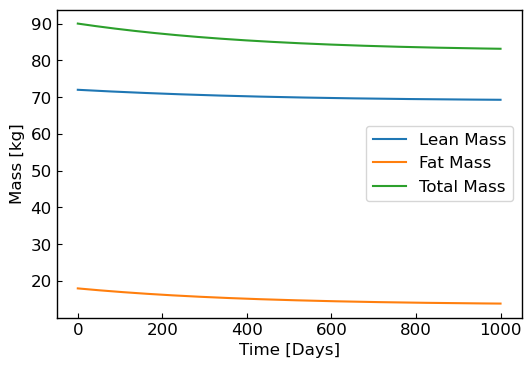

Final total mass: 83.2 kg
Final lean mass: 69.3 kg
Final fat mass: 13.9 kg


In [10]:
# Plot solution

# Figure and axis
fig, ax = plt.subplots(1, 1,figsize=(6, 4))
ax.plot(sol_noex.t, sol_noex.y[0], label="Lean Mass")
ax.plot(sol_noex.t, sol_noex.y[1], label="Fat Mass")
ax.plot(sol_noex.t, sol_noex.y[0] + sol_noex.y[1], label="Total Mass")

# Labels and legend
ax.set_xlabel("Time [Days]")
ax.set_ylabel("Mass [kg]")
ax.legend()
plt.show()

# Print final masses
print(f"Final total mass: {sol_noex.y[0][-1] + sol_noex.y[1][-1]:.1f} kg")
print(f"Final lean mass: {sol_noex.y[0][-1]:.1f} kg")
print(f"Final fat mass: {sol_noex.y[1][-1]:.1f} kg")

#### Energy Deficit: Consumption Minus Expenditure

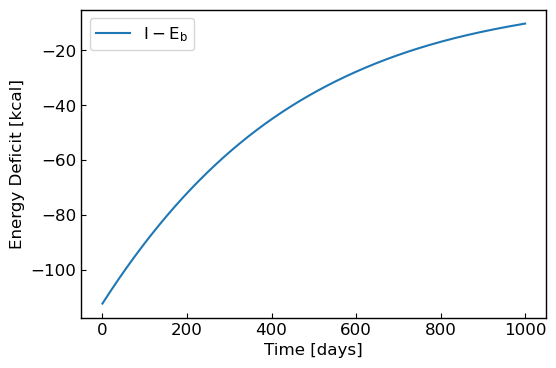

In [11]:
# Plot the energy deficit as a function of time
in_minus_out_noex = MJ_to_kcal(I0 - get_E_b(sol_noex.y[0], sol_noex.y[1]))
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(sol_noex.t, in_minus_out_noex, label=r"$I - E_b$")

# Labels and legend
ax.set_xlabel("Time [days]")
ax.set_ylabel("Energy Deficit [kcal]")
ax.legend()
plt.show()

## 1.4 Adding Exercise

In [12]:
# Aerobic power [mL/kg/min] and workout duration [min]
Qa_fun = lambda t: 0.5 * VO2_max
tau0 = 30

# Defining array of parameters
params = [I0, Qa_fun, tau0]

# Time to integrate over [day]
t = [0, 1000]
t_eval = np.linspace(t[0], t[1], 1000)

# Solve the system of differential equations
sol = solve_ivp(deriv, t, vals0, args=[params], t_eval=t_eval)

In [13]:
# Plot solution

# Figure and axis
fig, ax = plt.subplots(1, 1,figsize=(6, 4))
ax.plot(sol.t, sol.y[0], label="Lean Mass")
ax.plot(sol.t, sol.y[1], label="Fat Mass")
ax.plot(sol.t, sol.y[0] + sol.y[1], label="Total Mass")

# Labels and legend
ax.set_xlabel("Time [Days]")
ax.set_ylabel("Mass [kg]")
ax.legend()
plt.show()

# Print final masses
print(f"Final total mass: {sol.y[0][-1] + sol.y[1][-1]:.1f} kg")
print(f"Final lean mass: {sol.y[0][-1]:.1f} kg")
print(f"Final fat mass: {sol.y[1][-1]:.1f} kg")

Final total mass: 71.3 kg
Final lean mass: 63.4 kg
Final fat mass: 7.9 kg


#### Energy Deficit: Consumption Minus Expenditure

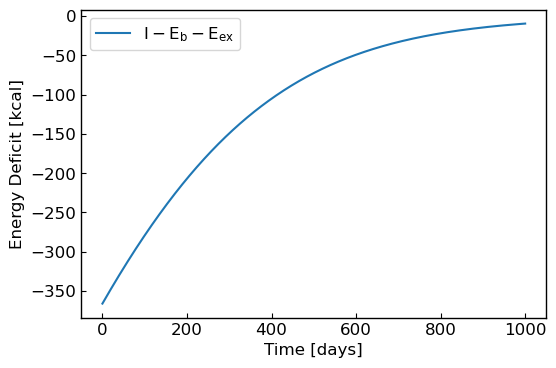

In [14]:
# Plot the energy deficit as a function of time

# In this case, we need to consider expenditure from both BMR and exercise
basal = get_E_b(sol.y[0], sol.y[1])
Qa = 20
exercise = (sol.y[0] + sol.y[1]) * VO2_to_MJ(Qa * tau0)

# Compute consumption minus expenditure and plot it
in_minus_out = MJ_to_kcal(I0 - basal - exercise)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(sol_noex.t, in_minus_out, label=r"$I - E_b - E_{ex}$")

# Labels and legend
ax.set_xlabel("Time [days]")
ax.set_ylabel("Energy Deficit [kcal]")
ax.legend()
plt.show()

## 1.5 Comparing Both Scenarios

#### Total Mass

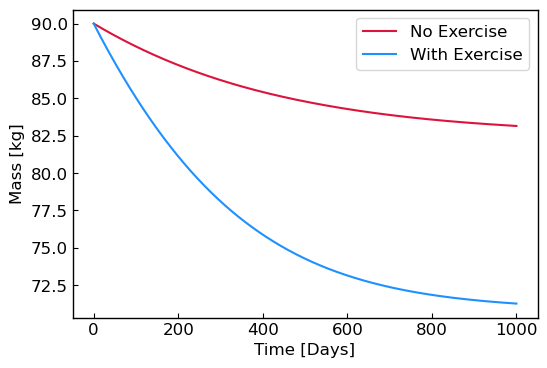

In [15]:
# Plot solution

# Figure and axis
fig, ax = plt.subplots(1, 1,figsize=(6, 4))
ax.plot(sol.t, sol_noex.y[0] + sol_noex.y[1], label="No Exercise", color="crimson")
ax.plot(sol.t, sol.y[0] + sol.y[1], label="With Exercise", color="dodgerblue")

# Labels and legends
ax.set_xlabel("Time [Days]")
ax.set_ylabel("Mass [kg]")
ax.legend()
plt.show()

#### Energy Deficit

In [16]:
# Plot energy deficit for both scenarios over time
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(sol_noex.t, in_minus_out_noex, label=r"$I - E_b$", color="crimson")
ax.plot(sol_noex.t, in_minus_out, label=r"$I - E_b - E_{ex}$", color="dodgerblue")

# Labels and legend
ax.set_xlabel("Time [days]")
ax.set_ylabel("Energy Deficit [kcal]")
ax.legend()
plt.show()

## 2. Sensitivity Analysis

### 2.1. Energy Intake, $I$

#### 2.1.1. No Exercise

In [17]:
# Setting the parameters we will fix
# Aerobic power and workout duration are 0
Qa_fun = lambda t: 0
tau0 = 0

# Array of intake values to try [kcal]
I_arr = np.linspace(1800, 2400, 6)

# Figure and colors to use for plotting
fig, ax = plt.subplots(1, 1,figsize=(6, 4))
colors = plt.cm.coolwarm(np.linspace(0, 1, len(I_arr)))

# Iterate over each value of I to evaluate
for j, I in enumerate(I_arr):
    # Solve the system of differential equations
    params = [kcal_to_MJ(I), Qa_fun, tau0]
    sol = solve_ivp(deriv, t, vals0, args=[params], t_eval=t_eval)
    # Plot the total mass and print its last value
    ax.plot(sol.t, sol.y[0] + sol.y[1], color=colors[j], label=r"$I$ = " + f"{I:.0f} kcal")
    print(f"I = {I:.0f} kcal, final mass: {(sol.y[0][-1] + sol.y[1][-1]):.1f} kg")
# Labels and legend
ax.set_xlabel("Time [days]")
ax.set_ylabel("Mass [kg]")
ax.legend()
plt.show()

I = 1800 kcal, final mass: 71.6 kg
I = 1920 kcal, final mass: 78.4 kg
I = 2040 kcal, final mass: 85.6 kg
I = 2160 kcal, final mass: 93.0 kg
I = 2280 kcal, final mass: 100.6 kg
I = 2400 kcal, final mass: 108.4 kg


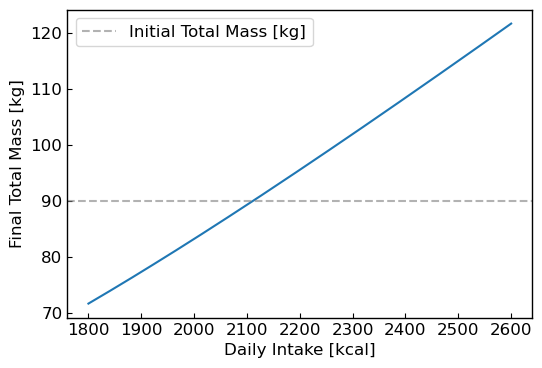

In [18]:
# Setting the parameters we will fix
# Aerobic power and workout duration are 0
Qa_fun = lambda t: 0
tau0 = 0

# Array of intake values to try [kcal]
I_arr = np.linspace(1800, 2600, 300)

# Array to store final masses
final_mass_noex = np.zeros(len(I_arr))

# Iterate over each value of I to evaluate
for j, I in enumerate(I_arr):
    # Solve the system of differential equations
    params = [kcal_to_MJ(I), Qa_fun, tau0]
    sol = solve_ivp(deriv, t, vals0, args=[params], t_eval=t_eval)
    final_mass_noex[j] = sol.y[0][-1] + sol.y[1][-1]

# Plot the final masses
fig, ax = plt.subplots(1, 1,figsize=(6, 4))
ax.plot(I_arr, final_mass_noex)

# Horizontal line with initial mass
plt.axhline(sum(vals0), linestyle="--", color="grey", alpha=0.6, label="Initial Total Mass [kg]")

# Labels and legend
ax.set_xlabel("Daily Intake [kcal]")
ax.set_ylabel("Final Total Mass [kg]")
ax.legend()
plt.show()

#### 2.1.2 With Exercise

I = 1800 kcal, final mass: 62.2 kg
I = 1920 kcal, final mass: 67.5 kg
I = 2040 kcal, final mass: 73.2 kg
I = 2160 kcal, final mass: 79.2 kg
I = 2280 kcal, final mass: 85.4 kg
I = 2400 kcal, final mass: 91.8 kg


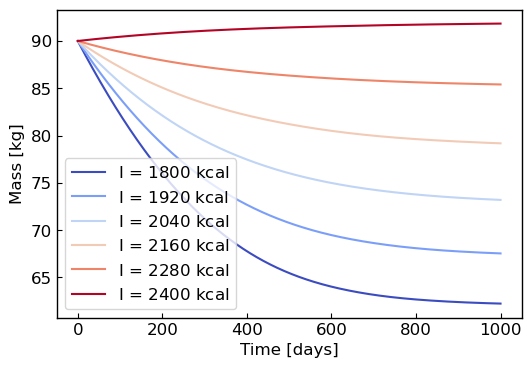

In [19]:
# Setting the parameters we will fix
# Aerobic power and workout duration are 0
Qa_fun = lambda t: 20
tau0 = 30

# Array of intake values to try [kcal]
I_arr = np.linspace(1800, 2400, 6)

# Figure and colors to use for plotting
fig, ax = plt.subplots(1, 1,figsize=(6, 4))
colors = plt.cm.coolwarm(np.linspace(0, 1, len(I_arr)))

# Iterate over each value of I to evaluate
for j, I in enumerate(I_arr):
    # Solve the system of differential equations
    params = [kcal_to_MJ(I), Qa_fun, tau0]
    sol = solve_ivp(deriv, t, vals0, args=[params], t_eval=t_eval)
    # Plot the total mass and print its last value
    ax.plot(sol.t, sol.y[0] + sol.y[1], color=colors[j], label=r"$I$ = " + f"{I:.0f} kcal")
    print(f"I = {I:.0f} kcal, final mass: {(sol.y[0][-1] + sol.y[1][-1]):.1f} kg")
# Labels and legend
ax.set_xlabel("Time [days]")
ax.set_ylabel("Mass [kg]")
ax.legend()
plt.show()

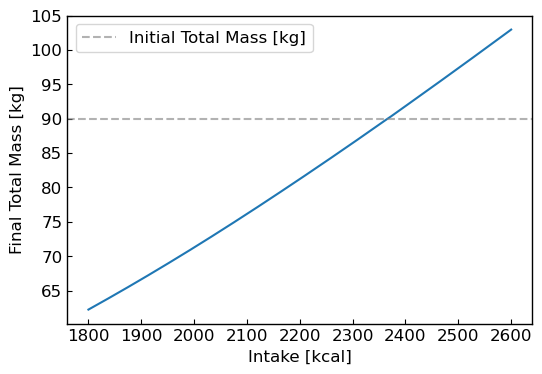

In [20]:
# Setting the parameters we will fix
# Aerobic power [ml/kg/min] and workout duration [min]
Qa_fun = lambda t: 20
tau_0 = 30

# Array of intake values to try [kcal]
I_arr = np.linspace(1800, 2600, 300)

# Array to store final masses
final_mass = np.zeros(len(I_arr))

# Iterate over each value of I to evaluate
for j, I in enumerate(I_arr):
    # Solve the system of differential equations
    params = [kcal_to_MJ(I), Qa_fun, tau_0]
    sol = solve_ivp(deriv, t, vals0, args=[params], t_eval=t_eval)
    final_mass[j] = sol.y[0][-1] + sol.y[1][-1]

# Plot the final masses
fig, ax = plt.subplots(1, 1,figsize=(6, 4))
ax.plot(I_arr, final_mass)

# Horizontal line with initial mass
plt.axhline(sum(vals0), linestyle="--", color="grey", alpha=0.6, label="Initial Total Mass [kg]")

# Labels and legend
ax.set_xlabel("Intake [kcal]")
ax.set_ylabel("Final Total Mass [kg]")
ax.legend()
plt.show()

#### 2.1.3. Overlaying the Two Scenarios

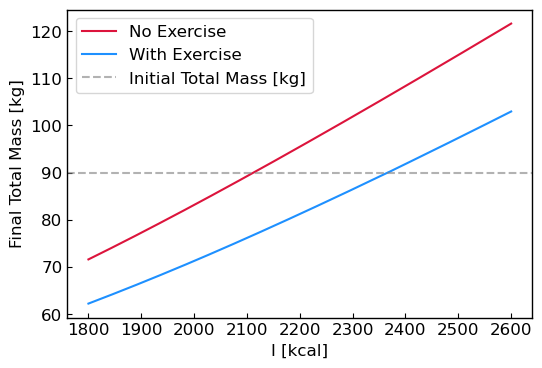

In [21]:
# Plot the final masses
fig, ax = plt.subplots(1, 1,figsize=(6, 4))
ax.plot(I_arr, final_mass_noex, label="No Exercise", color="crimson")
ax.plot(I_arr, final_mass, label="With Exercise", color="dodgerblue")

# Horizontal line with initial mass
plt.axhline(sum(vals0), linestyle="--", color="grey", alpha=0.6, label="Initial Total Mass [kg]")

# Labels and legend
ax.set_xlabel("I [kcal]")
ax.set_ylabel("Final Total Mass [kg]")
ax.legend()
plt.show()

### 2.2 Workout Duration, $\tau_0$

tau0 = 0 min, final mass: 83.2 kg
tau0 = 15 min, final mass: 76.7 kg
tau0 = 30 min, final mass: 71.3 kg
tau0 = 45 min, final mass: 66.8 kg
tau0 = 60 min, final mass: 63.1 kg


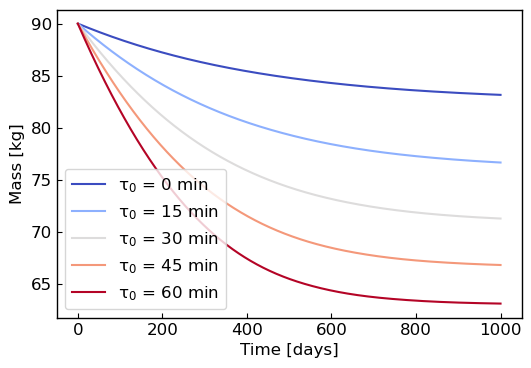

In [25]:
# Setting the parameters we will fix
Qa_fun = lambda t: 20

# Array of workout times to try
tau0_arr = np.linspace(0, 60, 5)

# Figure and colors for plot
fig, ax = plt.subplots(1, 1,figsize=(6, 4))
colors = plt.cm.coolwarm(np.linspace(0, 1, len(tau0_arr)))

# Iterate over different workout times
for i, tau0 in enumerate(tau0_arr):
    # Solve the system of differential equations
    params = [I0, Qa_fun, tau0]
    sol = solve_ivp(deriv, t, vals0, args=[params], t_eval=t_eval)
    # Plot the solution and print the final mass
    ax.plot(sol.t, sol.y[0] + sol.y[1], color=colors[i], label=r"$\tau_0$ = " + f"{tau0:.0f} min")
    ax.set_xlabel("Time [days]")
    ax.set_ylabel("Mass [kg]")
    print(f"tau0 = {tau0:.0f} min, final mass: {(sol.y[0][-1] + sol.y[1][-1]):.1f} kg")
plt.legend()
plt.show()

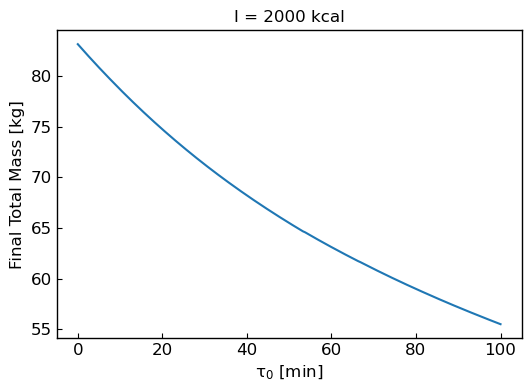

In [26]:
# Setting the parameters we will fix
# Intake [kcal → MJ] and aerobic power [ml/kg/min]
Qa_fun = lambda t: 20

# Array of intake values to try [kcal]
tau0_arr = np.linspace(0, 100, 200)

# Array to store final masses
final_mass = np.zeros(len(tau0_arr))
lean, fat = np.zeros(len(tau0_arr)), np.zeros(len(tau0_arr))

# Iterate over each value of I to evaluate
for i, tau0 in enumerate(tau0_arr):
    # Solve the system of differential equations
    params = [I0, Qa_fun, tau0]
    sol = solve_ivp(deriv, t, vals0, args=[params], t_eval=t_eval)
    final_mass[i] = sol.y[0][-1] + sol.y[1][-1]
    lean[i] = sol.y[0][-1]
    fat[i] = sol.y[1][-1]

# Plot the final masses
fig, ax = plt.subplots(1, 1,figsize=(6, 4))
# ax.plot(tau0_arr, lean, label="Final Lean Mass")
# ax.plot(tau0_arr, fat, label="Final Fat Mass")
ax.plot(tau0_arr, final_mass, label=" Mass")

# Labels and legend
ax.set_xlabel(r"$\tau_0$ [min]")
ax.set_ylabel("Final Total Mass [kg]")
ax.set_title(f"I = {MJ_to_kcal(I0):.0f} kcal", fontsize=12)
# ax.legend()
plt.show()

### 2.3. Changing Initial Body Composition

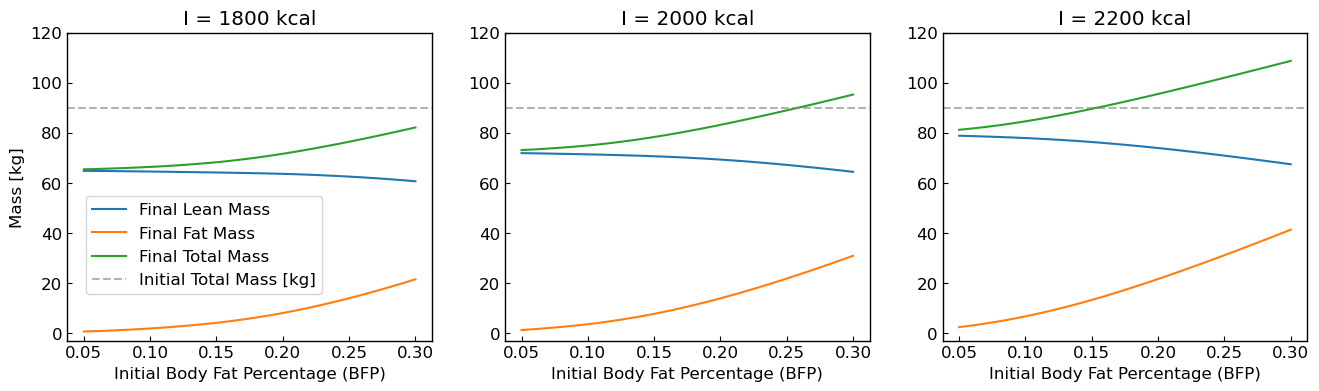

In [73]:
# Setting the parameters we will fix
# Consider no exercise initially
Qa_fun = lambda t: 0
tau0 = 0
params = [I0, Qa_fun, tau0]

# Initial total mass [kg] and array of BFPs to try
M = 90
bfp_arr = np.linspace(0.05, 0.3, 50)

# Different intake values to plot
I_arr = [1800, 2000, 2200]

# Figure to plot
fig, ax = plt.subplots(1, len(I_arr), figsize=(16, 4))

# Iterate over different intake values
for j, I in enumerate(I_arr):
    # Array to store final masses
    final_mass = np.zeros(len(bfp_arr))
    lean, fat = np.zeros(len(bfp_arr)), np.zeros(len(bfp_arr))
    params = [kcal_to_MJ(I), Qa_fun, tau0]
    # Iterate over each value of BFP to evaluate
    for i, bfp in enumerate(bfp_arr):
        # Solve the system of differential equations
        vals0 = [M * (1 - bfp), M * bfp]
        sol = solve_ivp(deriv, t, vals0, args=[params], t_eval=t_eval)
        final_mass[i] = sol.y[0][-1] + sol.y[1][-1]
        lean[i] = sol.y[0][-1]
        fat[i] = sol.y[1][-1]
    # Plot the final masses for this intake value I
    ax[j].plot(bfp_arr, lean, label="Final Lean Mass")
    ax[j].plot(bfp_arr, fat, label="Final Fat Mass")
    ax[j].plot(bfp_arr, final_mass, label="Final Total Mass")
    # Horizontal line with initial mass
    ax[j].axhline(sum(vals0), linestyle="--", color="grey", alpha=0.6, label="Initial Total Mass [kg]")
    # Axes limits and labels
    ax[j].set_ylim(-3, 120)
    ax[j].set_xlabel("Initial Body Fat Percentage (BFP)")
    ax[j].set_title(f"I = {I_arr[j]} kcal")

# Labels and legend
ax[0].set_ylabel("Mass [kg]")
ax[0].legend(loc=(0.05, 0.15))
plt.show()

### 2.4. Changing Aerobic Capacity Over Time
TODO